In [1]:
from gensim.models import LdaModel
import pickle as pkl
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from matplotlib import pyplot as plt

In [2]:
# Optimal number of topics
nTopics = 25

In [3]:
# Define colors to associate with each topic
custom_colors = {
 'burlywood': '#DEB887',
 'chocolate': '#D2691E',
 'crimson': '#DC143C',
 'darkgreen': '#006400',
 'darkorange': '#FF8C00',
 'darkslategrey': '#2F4F4F',
 'deepskyblue': '#00BFFF',
 'dimgray': '#696969',
 'firebrick': '#B22222',
 'gold': '#FFD700',
 'goldenrod': '#DAA520',
 'lawngreen': '#7CFC00',
 'lightcoral': '#F08080',
 'lightpink': '#FFB6C1',
 'mediumvioletred': '#C71585',
 'orangered': '#FF4500',
 'orchid': '#DA70D6',
 'royalblue': '#4169E1',
 'slateblue': '#6A5ACD',
 'springgreen': '#00FF7F',
 'steelblue': '#4682B4',
 'teal': '#008080',
 'turquoise': '#40E0D0',
 'yellow': '#FFFF00',
 'blueviolet': '#8A2BE2',
 'yellowgreen': '#9ACD32'}

# turn into a list
colorlist = []
for color in custom_colors.values():
    colorlist.append(tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))

In [4]:
# Define topic names
topic_names = [
    'Precipitation Variability & Extremes',
    'Hydrogeochemistry',
    'Uncertainty',
    'Soil Moisture',
    'Statistical Hydrology',
    'Rainfall-Runoff',
    'Precipitation Observation',
    'Modeling & Calibration',
    'Water Management',
    'Snow Hydrology',
    'Streamflow Processes',
    'Water Quality',
    'Channel Flow',
    'Floods',
    'Sediment & Erosion',
    'Climate Change',
    'Subsurface Flow & Transport',
    'Scaling & Spatial Varaibility',
    'Land Surface Fluxes',
    'Hydrogeology',
    'Human Interventions & Effects',
    'Land Cover',
    'Systems Hydrology',
    'Modeling & Forecasting',
    'Groundwater'
]

# Load Data

In [5]:
# Load model
lda_model = LdaModel.load(f'trained_models/trained_lda_model_{nTopics}')

In [6]:
# Load topic distributions
topic_distributions = np.load(f'data/topic_distributions_{lda_model.num_topics}.npy')

In [7]:
# Load raw corpus dataframe
with open('data/raw_corpus.pkl', 'rb') as f:
    corpus_df = pkl.load(f)

In [8]:
# Pull topics
topics = lda_model.show_topics(formatted=False, num_topics=nTopics, num_words=20)

# Create WordClouds and Trend Plots

In [9]:
# calculate time series
years = np.unique(corpus_df['Year'])
topic_distributions_by_year = np.zeros([len(years), lda_model.num_topics])
for y, year in enumerate(years):
    hm_year = topic_distributions[corpus_df['Year'] == year,:]
    topic_distributions_by_year[y,:] = np.sum(hm_year, axis=0) / np.sum(hm_year)

In [10]:
# create wordclouds
stop_words = stopwords.words('english')
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=3500,
                  height=3500,
                  max_words=15,
                  color_func=lambda *args, **kwargs: colorlist[t],
                  prefer_horizontal=1.0)

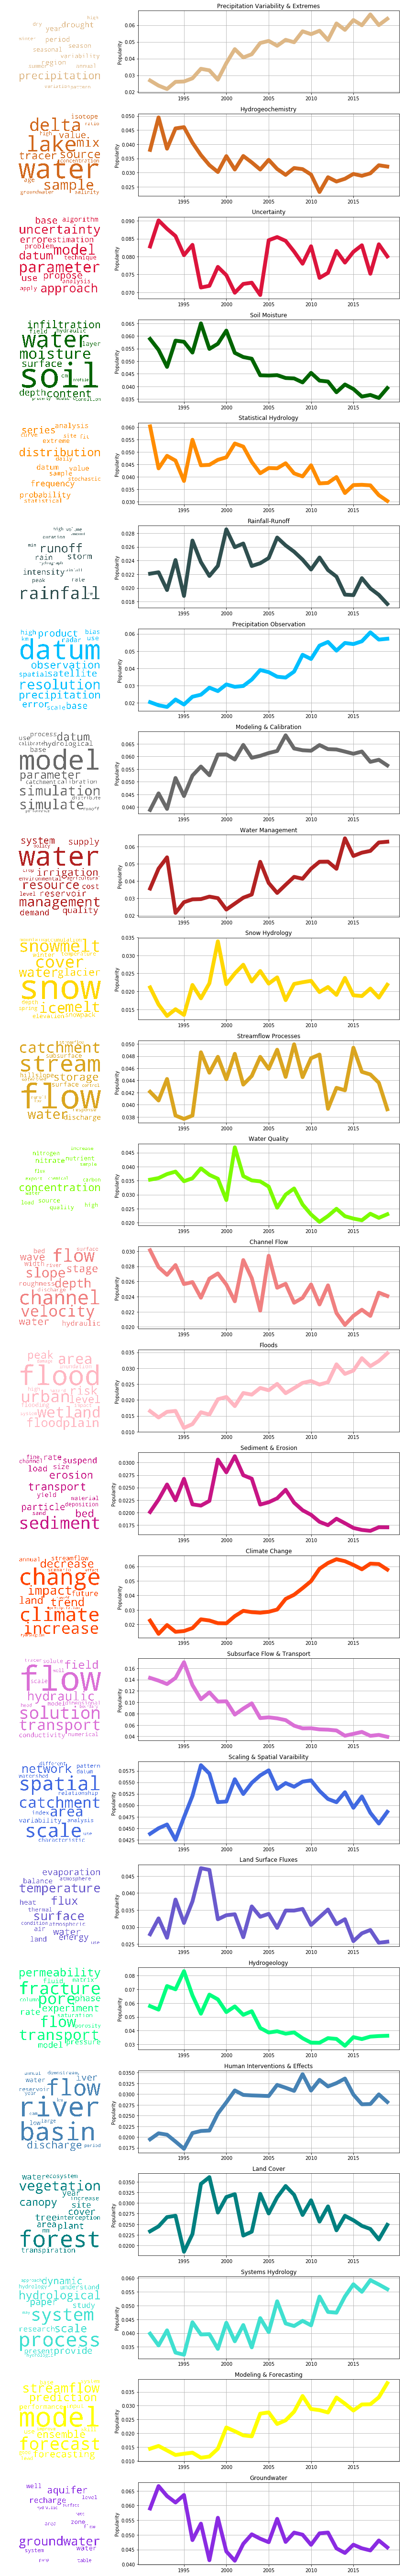

In [11]:
# Plot wordclouds and scaled time series
fig = plt.figure(figsize=(12, 3*nTopics))
gs = fig.add_gridspec(nTopics,3)
for t in range(nTopics):
    
    # plot time series
    ax1 = fig.add_subplot(gs[t, 1:])
    ax1.plot(years, topic_distributions_by_year[:,t], color=list(custom_colors.values())[t], linewidth=8)
    ax1.set_title(topic_names[t])
    ax1.set_xticks(years[4::5])
    ax1.set_ylabel('Popularity')
    ax1.grid()
    
    # plot wordclouds
    ax0 = fig.add_subplot(gs[t, 0])
    topic_words = dict(topics[t][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=1500)
    ax0.imshow(cloud)
    ax0.axis('off')
    
fig.tight_layout()

# Save figure
plt.savefig('figures/wordclouds_and_trends.png')

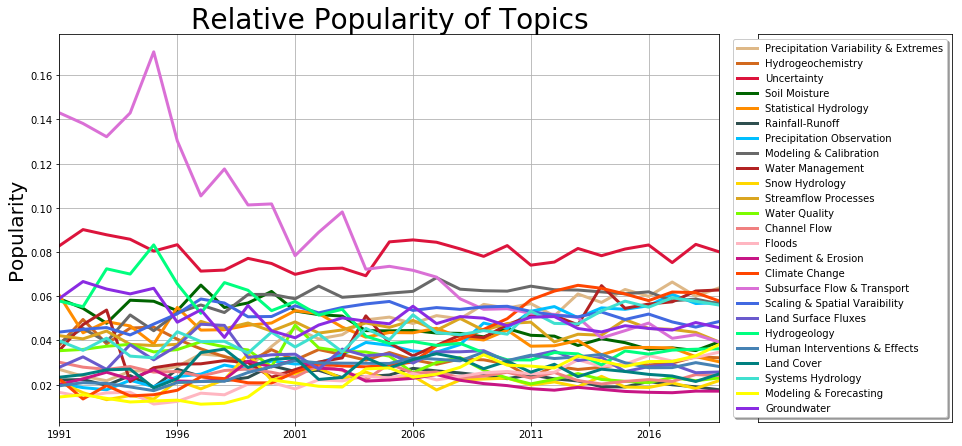

In [12]:
# Plot relative time series
fig = plt.figure(figsize=(16, 7.13))
gs = fig.add_gridspec(1,4)

ax1 = fig.add_subplot(gs[0, :3])
for i in range(lda_model.num_topics):
    r, g, b = colorlist[i] 
    pltcolor = (r / 255., g / 255., b / 255.)
    ax1.plot(years, topic_distributions_by_year[:,i], 
             c=pltcolor, linewidth=3, label=topic_names[i])
ax1.set_xticks(years[::5])
ax1.set_xlim([years[0], years[-1]])
ax1.set_ylabel('Popularity', fontsize=20)
ax1.set_title('Relative Popularity of Topics', fontsize=28)
ax1.grid()

ax0 = fig.add_subplot(gs[0, 3])
for i in range(lda_model.num_topics):
    r, g, b = colorlist[i] 
    pltcolor = (r / 255., g / 255., b / 255.)
    ax0.plot(years, topic_distributions_by_year[:,i], 
             c=pltcolor, linewidth=3, label=topic_names[i])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.legend(loc='best', shadow=True, fancybox = True)
for i in range(lda_model.num_topics):
    r, g, b = colorlist[i] 
    pltcolor = (r / 255., g / 255., b / 255.)
    ax0.plot(years, topic_distributions_by_year[:,i], 
             c='w', linewidth=6, label=topic_names[i])

# Save figure
plt.savefig('figures/relative_topic_trends.png')

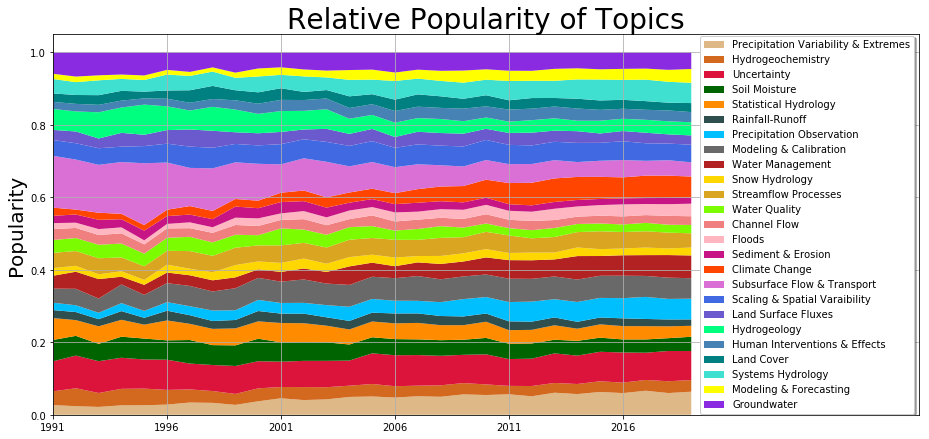

In [13]:
# Plot relative time series
fig = plt.figure(figsize=(21, 7))
gs = fig.add_gridspec(1,4)

ax1 = fig.add_subplot(gs[0, :3])
ax1.stackplot(years, topic_distributions_by_year.transpose(),labels=topic_names, colors=list(custom_colors.values()))
ax1.legend(topic_names, loc='center right', shadow=True)
ax1.set_xticks(years[::5])
ax1.set_xlim([years[0], 38])
ax1.set_ylabel('Popularity', fontsize=20)
ax1.set_title('Relative Popularity of Topics', fontsize=28)
ax1.grid()

# Save figure
plt.savefig('figures/stack_streamgraph_relative_topics.png')